In [58]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import pandas as pd
import cv2
import os
from matplotlib import pyplot as plt
%matplotlib inline

In [59]:
tf.logging.set_verbosity(tf.logging.INFO)

 # Load Data

In [60]:
def load_data(target):
    names=os.listdir(target)
    x=[]
    y=[]
    for i in names:
        path_target=os.path.join(target,i)
        path_image=os.listdir(path_target)
        for j in path_image:
            path_final=os.path.join(path_target,j)
            img=cv2.imread(path_final,0)
            img=cv2.resize(img,(32,32))
            x.append(img)
            y.append(i)
    return x,y

In [61]:
x_train,y_train=load_data("train/")
x_test,y_test=load_data("validation/")

In [62]:
x_train=np.array(x_train).astype("float32")
y_train=np.array(y_train)
x_test=np.array(x_test).astype("float32")
y_test=np.array(y_test)

In [63]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(1955, 32, 32) (1955,) (655, 32, 32) (655,)


In [64]:
def sub(data):
    data=pd.DataFrame(data,columns=["type"])
    a={'Apple Braeburn':0, 'Apple Golden':1,'Apple Red':2, 'Apple Red Delicious':3}
    data= data["type"].map(a)
    return data.values
    

In [65]:
y_train=sub(y_train)
y_test=sub(y_test)

In [66]:
y_train=y_train.astype("int32")
y_test=y_test.astype("int32")

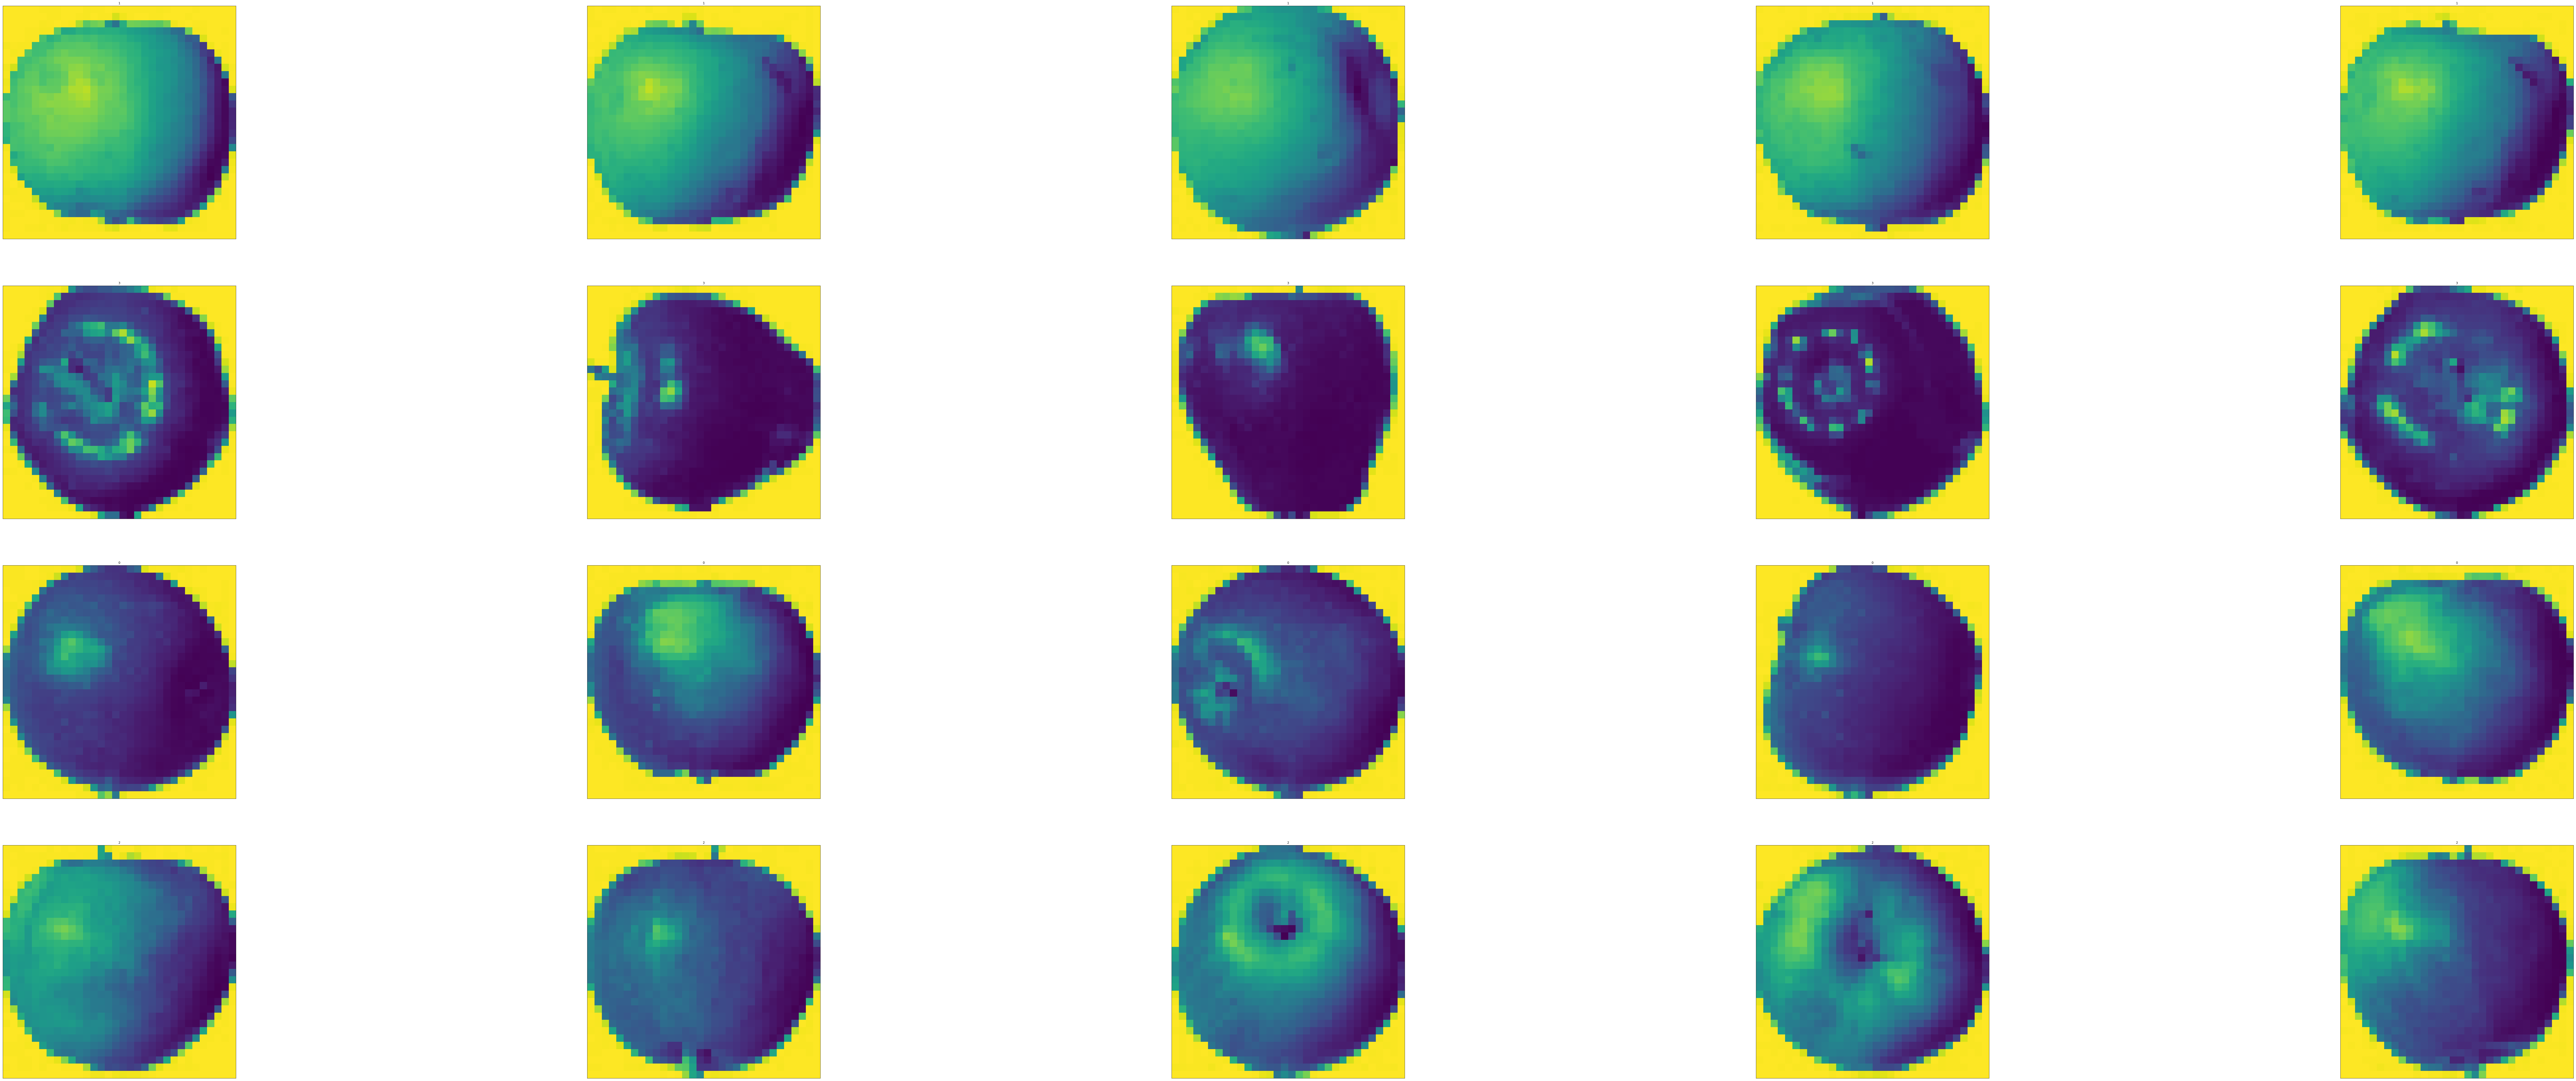

In [67]:
plt.figure(figsize=[200,200])
for i in range(1,1955,100):
    plt.subplot(10,5,i/100 +1)
    plt.imshow(x_train[i])
    plt.title(y_train[i])
    plt.xticks([]), plt.yticks([]) 

# Write into TFrecord

In [68]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

file="appletrain.tfrecords"
writer = tf.python_io.TFRecordWriter(file)

def convert_to(images, labels):
    num_examples = labels.shape[0]
    if images.shape[0] != num_examples:
        raise ValueError("Images size %d does not match label size %d." %
                     (images.shape[0], num_examples))
    rows = images.shape[1]
    cols = images.shape[2]
    
    with tf.python_io.TFRecordWriter(file) as writer:
        for index in range(num_examples):
            image_raw = images[index].tostring()
            label_raw = labels[index].tostring()
            example = tf.train.Example(features=tf.train.Features(feature={
                'height': _int64_feature(rows),
                'width': _int64_feature(cols),
                'label': _bytes_feature(label_raw),
                'image_raw': _bytes_feature(image_raw)}))
            writer.write(example.SerializeToString())


In [69]:
convert_to(x_train,y_train)

# Read From TFrecord

In [70]:
reconstructed_images = []
new_label=[]

record_iterator = tf.python_io.tf_record_iterator(path=file)

for string_record in record_iterator:
    
    example = tf.train.Example()
    example.ParseFromString(string_record)
    
    height = int(example.features.feature['height'].int64_list.value[0])
    
    width = int(example.features.feature['width'].int64_list.value[0])
    
    img_string = (example.features.feature['image_raw'].bytes_list.value[0])
    
    label = (example.features.feature['label'].bytes_list.value[0])
    
    img_1d = np.fromstring(img_string, dtype=np.uint8)
    reconstructed_img = img_1d.reshape((height, width, -1))
    
    label1 = np.fromstring(label, dtype=np.uint8)
    # Annotations don't have depth (3rd dimension)
   # reconstructed_annotation = label1.reshape((height, width))
    
    reconstructed_images.append(reconstructed_img)
    new_label.append(label1[0])

/home/atul/keras_opencv/lib/python3.5/site-packages/ipykernel_launcher.py:19: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/atul/keras_opencv/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
